# **FRUIT BOX CUSTOMER ANALYTICS**

En este punto se realiza un análisis de componentes principales (PCA) utilizando bosques aleatorios. 

Se cuenta con un conjunto de datos con 13 caracteristicas (columnas) y 178 observaciones (filas).


# 1. Dividir el conjunto de datos en entrenamiento y prueba.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel('dataset.xlsx',
                      header=None)

df.columns = ['tipo_caja', 'time_to_conversion', 'pages_per_visit', 'new_users_weekly',
                   'weight_kg', 'price_mean', 'transactions_weekly',
                   'resolution_time', 'net_promoter_score', 'login_weekly',
                   'customer_score', 'cost_per_visit', 'years_active',
                   'total_sales']

print('Tipos de cajas: S= 1; M=2; L=3')
print('Class labels', np.unique(df['tipo_caja']))

df.head()

Tipos de cajas: S= 1; M=2; L=3
Class labels [1 2 3]


,tipo_caja,time_to_conversion,pages_per_visit,new_users_weekly,weight_kg,price_mean,transactions_weekly,resolution_time,net_promoter_score,login_weekly,customer_score,cost_per_visit,years_active,total_sales
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

<br>
<br>

# 2. Ajustar las caracteristicas a la misma escala

In [3]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [4]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# 3. Seleccionar caracteristicas significativas

## Seleccion de caracteristicas sequenciales

In [5]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

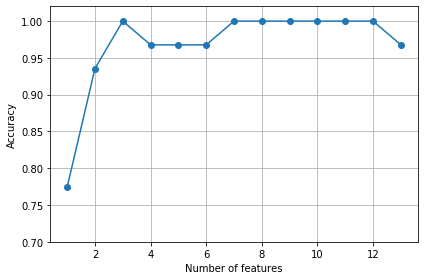

In [7]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [8]:
k3 = list(sbs.subsets_[10])
print(df.columns[1:][k3])

Index(['time_to_conversion', 'pages_per_visit', 'years_active'], dtype='object')


In [9]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [10]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


<br>
<br>

# 4. Evaluar la importancia de caracteristicas con bosques aleatorios

 1) total_sales                    0.185453
 2) resolution_time                0.174751
 3) customer_score                 0.143920
 4) years_active                   0.136162
 5) time_to_conversion             0.118529
 6) cost_per_visit                 0.058739
 7) transactions_weekly            0.050872
 8) price_mean                     0.031357
 9) pages_per_visit                0.025648
10) login_weekly                   0.025570
11) weight_kg                      0.022366
12) net_promoter_score             0.013354
13) new_users_weekly               0.013279


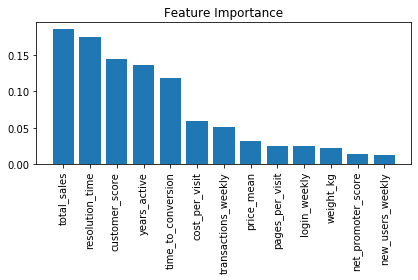

In [11]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

In [12]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', 
      X_selected.shape[0])

Number of samples that meet this criterion: 124
